<a href="https://colab.research.google.com/github/koreahong/parking_lot_analysis/blob/main/%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

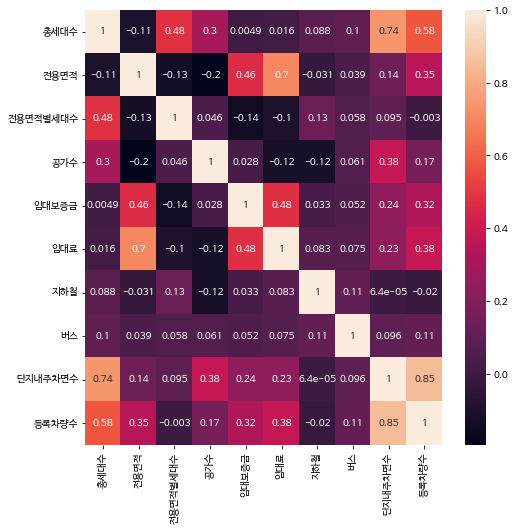

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
sns.heatmap(none_duplicate.corr(), annot=True)

- 총세대수, 전용면적, 임대보증금, 임대료, 단지내주차면수가 등록차량수와 밀접한 연관이 있음

### 가정1: 단지내에 상가가 있으면 주차장 수가 줄어들 것이다.

In [ ]:
train_code = train_copy[train_copy.임대건물구분 == '상가'].단지코드.unique()
test_code = test_copy[test_copy.임대건물구분 == '상가'].단지코드.unique()

In [ ]:
train_copy['상가유무'] = 1
train_copy['상가유무'] = train_copy.단지코드.apply(lambda x: '상가있음' if x in train_code else '상가없음')

In [ ]:
test_copy['상가유무'] = 1
test_copy['상가유무'] = test_copy.단지코드.apply(lambda x: '상가있음' if x in test_code else '상가없음')

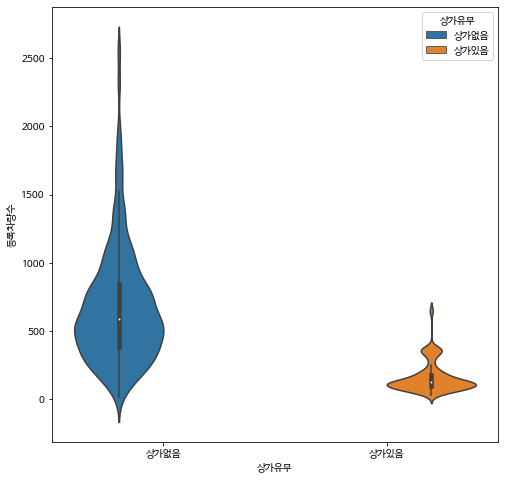

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
sns.violinplot(x="상가유무", y="등록차량수", data=train_copy, hue="상가유무")

- 단지내에 상가유무에 따라서 유의미한 차이가 있음 -> 상가로 인해서 주차장 면적이 줄어드는 것으로 판단

### 가정2: 전용면적합, 평균이 크고 단지내 아파트수가 많으면 등록차량수가 많아지지 않을까?

In [ ]:
temp = train_copy[train_copy.임대건물구분 == '아파트'].groupby('단지코드').agg({'전용면적':['mean', 'sum', 'count'], '전용면적별세대수':'mean', '등록차량수':'mean'}).reset_index()

In [ ]:
temp.columns = ['단지코드', '전용면적평균',  '전용면적총합', '단지내아파트개수', '전용면적별세대수평균', '등록차량수']

In [ ]:
temp.corr()

,전용면적평균,전용면적총합,단지내아파트개수,전용면적별세대수평균,등록차량수
전용면적평균,1.000000,0.412434,0.009750,-0.132637,0.425299
전용면적총합,0.412434,1.000000,0.872935,-0.364646,0.513212
단지내아파트개수,0.009750,0.872935,1.000000,-0.396460,0.400387
전용면적별세대수평균,-0.132637,-0.364646,-0.396460,1.000000,0.084180
등록차량수,0.425299,0.513212,0.400387,0.084180,1.000000


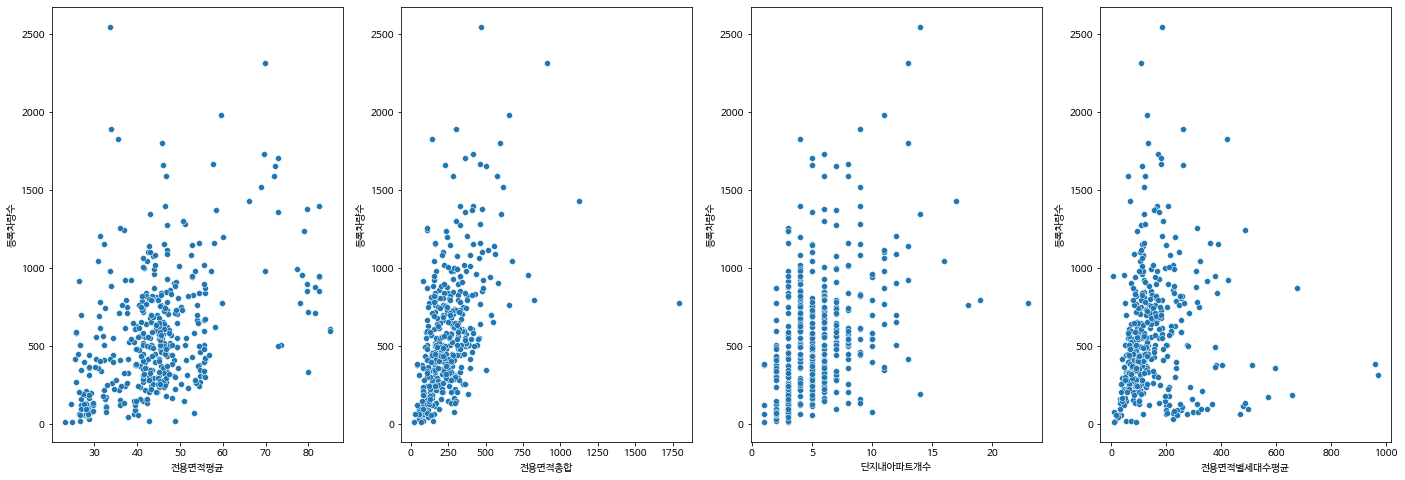

In [ ]:
fig , ax = plt.subplots(figsize=(24,8))
fig.set_facecolor('white')
count = 1
num = len(temp.columns[1:-1])
for i in temp.columns[1:-1]:
  plt.subplot(1, num, count)
  sns.scatterplot(x=i, y="등록차량수", data=temp)
  count+=1

### 모델 중요도

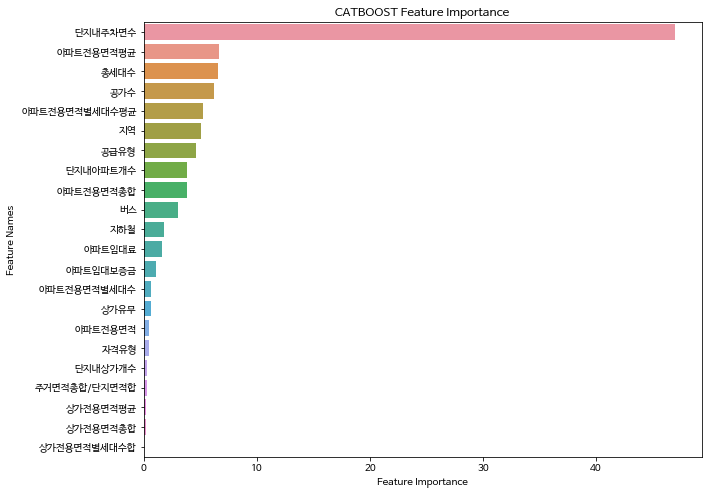

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    fig = plt.figure(figsize=(10,8))
    fig.set_facecolor("white")
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

# 효과없음

이런 생각도 할 수 있다.  
동일 단지코드내에 전용면적별세대수에 비례하지 않을까

In [ ]:
# 등록차량수, 단지내주차면수를 전용면적별세대수 비율에 맞추기
train_copy['비례단지내주차면수'] = round(train_copy['단지내주차면수'] * train_copy['전용면적별세대수'].div(train_copy.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum())))
train_copy['비례등록차량수'] = round(train_copy['등록차량수'] * train_copy['전용면적별세대수'].div(train_copy.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum())))

In [ ]:
test_copy['비례단지내주차면수'] = round(test_copy['단지내주차면수'] * test_copy['전용면적별세대수'].div(test_copy.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum())))

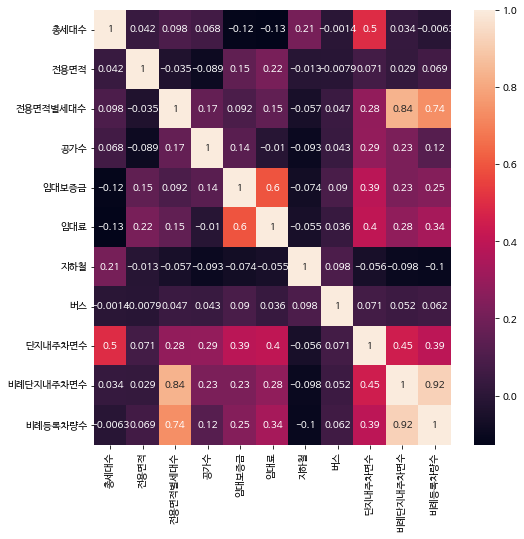

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
sns.heatmap(train_copy.corr(), annot=True)